### Rating Prediction using Pearson Coefficients
The idea is very simple: we are going to implement a user-user recommendation system based on the similarity between two users. This similarity is calculated using the Pearson correlation coefficients.\
The main object of this exercise is the **Ratings Matrix** $R(N\times M)$, where $N$ is the number of users and $M$ is the number of movies. Notice that this is a **sparse matrix** because each user has rated only a few of the possible movies.
#### Collaborative Filtering
The goal is to compute a score for each user $i$, associated to each movie $j$:
$$s(i,j)=\hat{r}_{ij}$$
where $\hat{r}_{ij}$ is an element of the ratings matrix. The algorithm needs to implement the following equation, which takes into account the deviation from the average rating for each user, since each user has its own rating method:
$$s(i,j)=\bar{r}_i + \frac{\sum_{i'\in \Omega_j}w_{ii'}(r_{i'j}-\bar{r}_{i'})}{\sum_{i'\in \Omega_j}|w_{ii'}|}$$
with:
$$w_{ii'} = \frac{\sum_{j\in\psi_{ii'}}(r_{ij}-\bar{r}_i)(r_{i'j}-\bar{r}_{i'})}{\sqrt{\sum_{j\in\psi_{ii'}}(r_{ij}-\bar{r}_i)^2} \sqrt{\sum_{j\in\psi_{ii'}}(r_{i'j}-\bar{r}_{i'})^2}}$$
where: 
- $\Omega_j$ is the number of ratings for the movie $j$,
- $\psi_{ii'}$ is the set of movies rated by both $i$ and $i'$.

In [168]:
import pandas as pd

# Load the data
rating_df = pd.read_csv('archive/rating.csv')

In [169]:
# Take a look at the data
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [170]:
# Keep only the relevant columns
rating_df = rating_df[['userId', 'movieId', 'rating']]
rating_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


As you can see, this structure is a bit different from the Ratings Matrix defined earlier. We now preprocess the data in order to replicate the $R(N\times M)$ matrix.

In [171]:
# How many users are there? Are there some values missing?
print('Unique users: ', rating_df['userId'].nunique())
print('Min userId = ', rating_df['userId'].min())
print('Max userId = ', rating_df['userId'].max())

Unique users:  138493
Min userId =  1
Max userId =  138493


In [172]:
# All the userId's are used, so just subtract the min from the max to get the number of users
rating_df['userId'] = rating_df['userId'] - rating_df['userId'].min()

print('Unique users: ', rating_df['userId'].nunique())
print('Min userId = ', rating_df['userId'].min())
print('Max userId = ', rating_df['userId'].max())

Unique users:  138493
Min userId =  0
Max userId =  138492


In [173]:
# This is not valid for the movieId, so we need to reindex the movieId's
print('Unique movies: ', rating_df['movieId'].nunique())
print('Min movieId = ', rating_df['movieId'].min())
print('Max movieId = ', rating_df['movieId'].max())

Unique movies:  26744
Min movieId =  1
Max movieId =  131262


In [174]:
# Map the movieId's to a new range
# Create a dictionary with the new index as value and the old index as key
movieId_map = {movieId: i for i, movieId in enumerate(rating_df['movieId'].unique())}
# Use the map function to replace the old index with the new one
rating_df['movieId'] = rating_df['movieId'].map(movieId_map)
print('Unique movies: ', rating_df['movieId'].nunique())
print('Min movieId = ', rating_df['movieId'].min())
print('Max movieId = ', rating_df['movieId'].max())

Unique movies:  26744
Min movieId =  0
Max movieId =  26743


In [175]:
# Save the data
rating_df.to_csv('processed_data/rating.csv', index=False)

Notice that `rating_df` does not contain the movie titles, therefore we have to apply either an inverse mapping to these new indexes or the same mapping to the `movie.csv` dataset.

We now want to shrink the data since the dataset is too big to perform a $O(N^2)$ algorithm. We therefore select only the users who have rated the most number of movies and the movies that have been rated the most number of times.

In [176]:
rating_df = pd.read_csv('processed_data/rating.csv')

# Select only the top n users by number of ratings
n = 1000
user_index = rating_df.groupby('userId').count().sort_values('rating', ascending=False).head(n).index
rating_df = rating_df[rating_df['userId'].isin(user_index)]

# Select only the top m movies by number of ratings
m = 200
movie_index = rating_df.groupby('movieId').count().sort_values('rating', ascending=False).head(m).index
rating_df = rating_df[rating_df['movieId'].isin(movie_index)]

In [177]:
# We effectively reduced the database length, now remap the userId's and movieId's
user_map = {userId: i for i, userId in enumerate(rating_df['userId'].unique())}
movie_map = {movieId: i for i, movieId in enumerate(rating_df['movieId'].unique())}
rating_df['userId'] = rating_df['userId'].map(user_map)
rating_df['movieId'] = rating_df['movieId'].map(movie_map)

# Remove the old index
rating_df.reset_index(drop=True, inplace=True)

# Save the data
rating_df.to_csv('processed_data/rating.csv', index=False)

We now split the dataset in train and test sets. We then define 3 dictionaries to alleviate the computational complexity and to have a better view on the problem.

In [178]:
from sklearn.model_selection import train_test_split

# Split the data into train and test, shuffling the data
train_df, test_df = train_test_split(rating_df, test_size=0.2, random_state=42)

In [179]:
# Dictionary containing users and the movies they rated
user_movie = {}
# Dictionary containing movies and the users that rated them
movie_user = {}
# Dictionary containing the ratings for each user-movie pair
user_movie_rating = {}

# Fill the dictionaries
def fill_dict(row):
    i = int(row['userId'])
    j = int(row['movieId'])

    # Update the user-movie dictionary
    if i not in user_movie:
        # Define a new key
        user_movie[i] = [j]
    else:
        # Append the movieId to the list of movies for that user
        user_movie[i].append(j)

    # Update the movie-user dictionary
    if j not in movie_user:
        # Define a new key
        movie_user[j] = [i]
    else:
        # Append the userId to the list of users for that movie
        movie_user[j].append(i)

    # Update the user-movie-rating dictionary
    user_movie_rating[(i, j)] = row['rating']

# Apply the function to the train data
train_df.apply(fill_dict, axis=1);

In [180]:
# Do the same for the test data, but we only need the user-movie rating pairs
test_user_movie_rating = {}
def fill_test_dict(row):
    i = int(row['userId'])
    j = int(row['movieId'])
    test_user_movie_rating[(i, j)] = row['rating']

test_df.apply(fill_test_dict, axis=1);

We are now ready to go. Let's build a class that takes care of the training and also testing process, using the dictionaries we have just created.

In [188]:
from tqdm import tqdm
from itertools import islice

class PearsonRating():
    # The inputs are the user-movie dictionary, the movie-user dictionary, and the user-movie-rating dictionary
    def __init__(self, user_movie, movie_user, user_movie_rating):
        self.user_movie = user_movie
        self.movie_user = movie_user
        self.user_movie_rating = user_movie_rating
        self.user_mean = {}
        self.weights = {}
        self.predictions = {}

    # Calculate the mean rating for each user
    def compute_mean(self):
        for user in self.user_movie:
            self.user_mean[user] = sum([self.user_movie_rating[(user, movie)] for movie in self.user_movie[user]]) / len(self.user_movie[user])

    # Calculate the Pearson correlation between two users i and j
    def compute_weight(self, i, j):
        # Compute the mean rating for the users if it hasn't been done yet
        if self.user_mean == {}:
            self.compute_mean()
        # Get the movies that both users have rated
        common_movies = list(set(self.user_movie[i]).intersection(self.user_movie[j]))
        # If there are no common movies, return 0
        if len(common_movies) == 0:
            return 0
        # Calculate the numerator and the denominators
        num = sum([self.user_movie_rating[(i, movie)] - self.user_mean[i] for movie in common_movies]) * sum([self.user_movie_rating[(j, movie)] - self.user_mean[j] for movie in common_movies])
        den1 = sum([(self.user_movie_rating[(i, movie)] - self.user_mean[i])**2 for movie in common_movies])
        den2 = sum([(self.user_movie_rating[(j, movie)] - self.user_mean[j])**2 for movie in common_movies])
        # Calculate the similarity, exluding the case where the denominator is 0
        if den1 * den2 == 0:
            return 0
        else:
            return num / (den1 * den2)**0.5
    
    # Compute all the weights for the users
    def compute_all_weights(self):
        for i in tqdm(self.user_movie, desc='Weights'):
            for ii in self.user_movie:
                if i != ii:
                    self.weights[(i, ii)] = self.compute_weight(i, ii)
    
    # Calculate the prediction for user i and movie j
    def predict(self, i, j, k=10):
        # Select only the first k highest weights
        weights = {user_pair: weight for user_pair, weight in zip(self.weights.keys(), self.weights.values()) if user_pair[0] == i}
        # Using the abs() function to sort the weights by their absolute value, considering both positive and negative strong correlations
        weights = {user_pair: weight for user_pair, weight in sorted(weights.items(), key=lambda x: abs(x[1]), reverse=True)}
        # Use a custom function to take the first k elements of the dictionary and return them as a new dictionary
        weights = dict(islice(weights.items(), k))

        # If we have already calculated the prediction, return it
        if (i, j) in self.predictions:
            return self.predictions[(i, j)]
        # Get the users that have rated the movie
        users = self.movie_user[j]
        num = 0
        den = 0
        # Calculate the prediction (score for the movie)
        for user in users:
            # Get the weight for the user pair
            if (i, user) in weights:
                weight = weights[(i, user)] 
                # Get the mean rating for the user
                mean = self.user_mean[user]
                # Calculate the numerator and the denominator
                num += weight * (self.user_movie_rating[(user, j)] - mean)
                den += abs(weight)
        # If the denominator is 0, return the mean rating for the user
        if den == 0:
            return self.user_mean[i]
        else:
            return self.user_mean[i] + num / den
        
    # Predict the ratings for all the user i movie j pairs in the dataset
    def predict_all(self, data, k=10):
        if self.weights == {}:
            self.compute_all_weights()
        self.predictions = {}
        for (i, j) in tqdm(data, desc='Predictions'):
            self.predictions[(i, j)] = self.predict(i, j, k)

    # Evaluate the predictions using the MSE for regression
    def evaluate(self, data):
        if len(self.predictions) < len(data):
            self.predict_all(data)
        mse = 0
        # Compute the MSE for the data, i.e. the train/test user-movie-rating dictionary
        for (i, j) in data:
            if (i, j) in self.predictions:
                mse += (self.predictions[(i, j)] - data[(i, j)])**2
        return mse / len(data)
    

In [185]:
# Create the model
model = PearsonRating(user_movie, movie_user, user_movie_rating)

In [190]:
# Predict the ratings for the whole training set
model.compute_all_weights()

Weights: 100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


In [191]:
# Evaluation on the test set
model.predict_all(test_user_movie_rating)
print('MSE test set = ', model.evaluate(test_user_movie_rating))

Predictions: 100%|██████████| 34389/34389 [35:51<00:00, 15.99it/s]  

MSE test set =  0.9048972232554833


In [194]:
# Plot the predictions for the test set: given a user, plot the true and predicted ratings for the movies
import matplotlib.pyplot as plt

def plot_predictions(user):
    # Get the movies that the user has rated
    movies = user_movie[user][:10]
    movies.sort()
    # Get the true ratings
    true_ratings = [user_movie_rating[(user, movie)] for movie in movies]
    # Get the predicted ratings
    predicted_ratings = [model.predict(user, movie) for movie in movies]
    # Create a dataframe with the true and predicted ratings
    df = pd.DataFrame({'True': true_ratings, 'Predicted': predicted_ratings}, index=movies)
    # Plot the dataframe
    df.plot(kind='bar', figsize=(15, 5))
    plt.title(f'User {user} - True vs Predicted ratings')
    plt.xlabel('Movie')
    plt.ylabel('Rating')
    plt.grid(linestyle='--', alpha=0.3)
    plt.show()

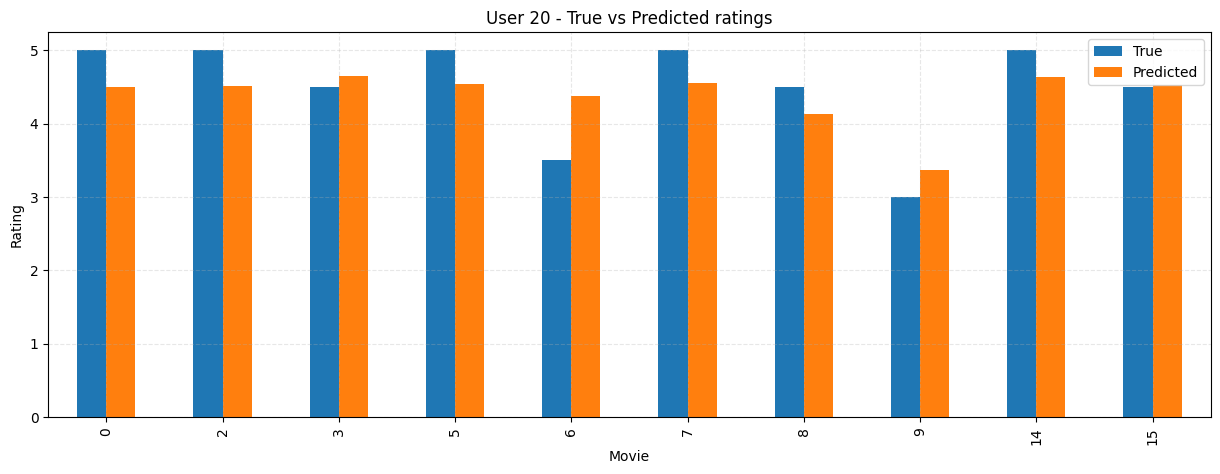

In [195]:
plot_predictions(20)

The predictive power is outstanding! A very nice feature is that we are only using the first 25 highest weights and, actually, we could even use less. Furthermore, even on a smaller dataset, the MSE is quite low. The major problem of this algorithm is the computational complexity and the very long time of execution.